## Contents
1. [Overview](#overview)
2. [Business Understanding](#business-understanding)
3. [The Data](#the-data)
    - [Overview of the Data](#overview-of-the-data)
    - [Data / Text Preprocessing](#data--text-preprocessing)
4. [Modeling](#modeling)
    - [Overview of Modeling](#overview-of-modeling)
    - [Approach 1 - Binary Classification](#approach-1---binary-classification)
        - [Binary Model Rationale](#binary-model-rationale)
        - [1. Logistic Regression](#1-logistic-regression)
        - [2. Naive Bayes](#2-naive-bayes)
        - [3. Random Forest (Binary)](#3-random-forest-binary)
    - [Approach 2 - Multiclass Classification](#approach-2---multiclass-classification)
        - [Multiclass Model Rationale](#multiclass-model-rationale)
        - [1. K-Nearest Neighbors](#1-k-nearest-neighbors)
        - [2. Decision Tree](#2-decision-tree)
        - [3. Random Forest](#3-random-forest-multiclass)
        - [4. Neural Network](#4-neural-network)
5. [Model Selection](#model-selection)

## Overview
Our data analytics firm, Flatiron Analytics, has been hired by SXSW to perform sentiment analysis on tweets from the festival. This project analyses a data set crowdsourced by festival goers to assess positive or negative emotions towards Apple and Google products. Based on our analysis results, we will identify which product brand has the most positive association amongst festival goers.

## Business Understanding
SXSW wants to develop a new app for their festival and is deciding whether to deploy it on the Apple Store or Google Play Store. Flatiron Analytics has been tasked with developing a predictive model to accurately identify whether a given tweet displays “positive,” “negative,” or “neutral” emotion towards Apple and Google devices. Our analysis will provide SXSW with a clear direction on which Store to deploy their new app and how to utilize our predictive models for future festivals.

## The Data

### Overview of the Data

Our analysis data was pulled from [Data World](https://data.world/crowdflower/brands-and-product-emotions) and included 8,700 tweets from the 2011 SXSW festival. Sentiments for each tweet were crowd-sourced where the crowd "was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product”. The dataset includes information about the text of each tweet, the product the tweet was directed at, and the emotion exhibited towards that product.

### Data / Text Preprocessing
Before delving into sentiment analysis, it's paramount that we preprocess the textual data for analysis. Preprocessing refines the raw tweets into a more manageable and interpretable form, essential for accurate modeling. We've employed a multi-step approach using the Natural Language Toolkit (NLTK) to remove special characters, normalize case, tokenize, filter out stopwords, and lemmatize the text. To do so, we introduce a Python function to preprocess tweets for Natural Language Processing (NLP) tasks. The function employs a sequence of operations to clean, tokenize, and lemmatize tweet text. The purpose is to transmute raw tweets into a refined form that enables more accurate and efficient text analysis.

Steps:
1. **Special Character Removal**: Eliminates non-alphabetic characters to make the text more uniform.
2. **Case Normalization**: Converts all text to lowercase to neutralize case sensitivity.
3. **Tokenization**: Breaks the text into individual words for easier manipulation.
4. **Stopword Removal**: Filters out commonly-used words that usually don't contribute to the meaning of a sentence.
5. **Word Length Filtering**: Removes words that are too short and are likely to be irrelevant.
6. **POS Tagging and Lemmatization**: Assigns Parts of Speech (POS) tags and reduces words to their base or root form.

The function utilizes the `nltk` library and is designed to operate on a Pandas Series representing the unprocessed text, and we pass in the `'unprocessed_tweet'` column along with a defined list of stop words. The function then returns the processed text Series, making it ready for subsequent NLP applications:

In [1]:
import pandas as pd  
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import nltk                                  # Import the Natural Language Toolkit (nltk) for text processing

nltk.download("wordnet")                     # Download the WordNet lexicon for lemmatization
nltk.download("stopwords")                   # Download the list of stopwords for filtering
nltk.download('punkt')                       # Download the Punkt tokenizer models for sentence splitting and tokenization
nltk.download('averaged_perceptron_tagger')  # Download the averaged perceptron tagger for Part-of-Speech tagging
nltk.download('words');                      # Download the words corpus for additional word resources

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aungs_tko91wk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aungs_tko91wk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aungs_tko91wk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aungs_tko91wk\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aungs_tko91wk\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [11]:
# Load tweets csv with ISO encoding, which handles special characters
df = pd.read_csv("data/tweets.csv", encoding='ISO-8859-1')

In [12]:
# Checking the null count
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

We'll go ahead and drop that one null value in the `'tweet_text'` column.

In [13]:
df = df.dropna(subset=["tweet_text"])
df.isnull().sum()

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5801
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [14]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pandas as pd  # Importing Pandas for data manipulation

# Map POS tag to first character for use in WordNetLemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to NOUN

# Remove special characters using a regex pattern
def remove_special_chars(text_series, pattern="[^a-zA-Z\s]"):
    return text_series.str.replace(pattern, "", regex=True)

# Convert text to lowercase
def to_lower(text_series):
    return text_series.str.lower()

# Tokenize text using word_tokenize from NLTK
def tokenize_text(text_series):
    return text_series.apply(lambda t: word_tokenize(str(t)))

# Remove stopwords
def filter_stopwords(tokenized_text, stop_words):
    return tokenized_text.apply(lambda x: [word for word in x if word not in stop_words])

# Remove short words
def filter_length(tokenized_text, min_len=1):
    return tokenized_text.apply(lambda x: [word for word in x if len(word) > min_len])

# POS tagging and lemmatization
def tag_and_lemmatize(tokenized_text):
    lemmatizer = WordNetLemmatizer()
    tagged_text = tokenized_text.apply(lambda x: pos_tag(x))
    return tagged_text.apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in x])

# Master function to apply all preprocessing steps
def preprocess_text(stop_words: list, text: pd.Series) -> pd.Series:
    
    # Apply the preprocessing functions
    text = remove_special_chars(text)
    text = to_lower(text)
    tokenized_text = tokenize_text(text)
    filtered_text = filter_stopwords(tokenized_text, stop_words)
    filtered_text = filter_length(filtered_text)
    lemmatized_text = tag_and_lemmatize(filtered_text)
    
    # Convert list of words back to string
    lemmatized_str = lemmatized_text.apply(lambda x: ' '.join(x))
    
    return lemmatized_str

# Create list of stopwords
stop_words = stopwords.words("english")
stop_words = [i.replace("'", '') for i in stop_words]
top_words = ['sxsw', 'mention', 'link', 'rt']
stop_words = stop_words + top_words

# Rename DataFrame columns and apply the master function
df.columns = ["unprocessed_tweet", "product", "emotion"]
unprocessed_text = df["unprocessed_tweet"]

result = preprocess_text(stop_words, unprocessed_text)

print(result)

0       wesley iphone hr tweet riseaustin dead need up...
1       jessedee know fludapp awesome ipadiphone app l...
2                          swonderlin wait ipad also sale
3               hope year festival crashy year iphone app
4       sxtxstate great stuff fri marissa mayer google...
                              ...                        
9088                                      ipad everywhere
9089    wave buzz interrupt regularly schedule geek pr...
9090    google zeiger physician never report potential...
9091    verizon iphone customer complain time fell bac...
9092                            google test checkin offer
Name: unprocessed_tweet, Length: 9092, dtype: object


In [15]:
# Store the processed text back into the dataframe
df["processed_tweet"] = result

df.head()

,unprocessed_tweet,product,emotion,processed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...


In [16]:
df.isnull().sum()

unprocessed_tweet       0
product              5801
emotion                 0
processed_tweet         0
dtype: int64

## Evaluation Metric

Before we get to modeling, we'll need a north star to assess the model's performance. It’s often the case, in a business problem, that we focus on either minimizing false negatives or false positives. In this case, there’s no distinction between the two. For example, a positive tweet classified as a negative holds no more value to our business problem than a negative tweet classified as a positive. Because of this, **we chose accuracy as our evaluation metric**. Accuracy, in this case, is how well our model predicts the actual sentiment of a tweet.

## Modeling

### Overview of Modeling

We trained the data on multiple predictive models with many different iterations. We took two approaches—Binary Classification and Multiclass Classification. For feature extraction, we employed the Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer. Additionally, we utilized a pipeline architecture, facilitating hyperparameter tuning and model selection.

Ultimately, our Binary classifier (Random Forest Classifier) performed the best, predicting tweet sentiment with an accuracy score of 85%. This model focused exclusively on tweets marked as having either a positive or negative emotion. On the other hand, our Ternary and Neural Ternary Classifiers included tweets marked as neutral or having no sentiment, complicating their predictive accuracy.

In [17]:
# Import the TFIDF Vectorizer and Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Import function to train-test-split and cross validation function
# Import cross val predict to aid in plotting cross validation confusion matrices
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

# Import confusion matrix function, plotter, and accuracy score function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### Approach 1 - Binary Classification

#### Binary Model Rationale

We employed a variety of models, coupled with hyperparameter tuning, to achieve the most robust results.

1. **Logistic Regression**: We initiated our analysis with Logistic Regression due to its simplicity and efficiency. It serves as a solid baseline model for binary classification problems, being both interpretable and effective. The model was encapsulated within a pipeline for streamlined preprocessing and model fitting, with hyperparameter tuning to optimize its predictive power.

2. **Naive Bayes**: This model was chosen for its computational efficiency and suitability for text classification tasks. It's particularly effective when the feature dimensions are high, as is often the case with text data. However, a limitation we encountered was that the pipeline wouldn't permit simultaneous hyperparameter tuning of both the Naive Bayes model and the TF-IDF Vectorizer. As a consequence, only the model itself was fine-tuned.

3. **Random Forest Classifier**: Our final model in this approach was a Random Forest Classifier. This ensemble model is better able to handle large datasets with nonlinearity, so we were curious to see how it would perform. Hyperparameter tuning further refined its predictive capabilities.

In [18]:
# Import models for binary classification
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Import GridSearchCV for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

Each of these models underwent tuning via `GridSearchCV` to ensure the most accurate and generalized predictions. Among them, the Random Forest Classifier yielded the highest accuracy, making it our model of choice for the Binary approach.

Before proceeding, the first step is to prune the original dataframe such that we keep only entries with either a positive or negative emotion label. After that, we encoded the emotions into integer (we label positive emotions as 1 and negatives as 0), starting with the Binary Classification model:

In [19]:
# Create a copy of the original dataframe
df_binary = df.copy()

# Define emotions for the binary model
binary_emotions = ["Negative emotion", "Positive emotion"]

# Prune the dataframe to only include positive and negative emotions
df_binary = df_binary[df_binary["emotion"].isin(binary_emotions)]

df_binary["emotion"].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

It's worth noting that the dataset exhibits an imbalance in the distribution of classes, with 2,978 instances labeled as "Positive emotion" and 570 as "Negative emotion." While the dataset is skewed, it is not severely imbalanced, which allows for meaningful analysis and model training. Nonetheless, we'll be cognizant of this as we go through the modeling process.

In [20]:
# Create a dictionary to map emotions to numerical codes
emotion_map = {"Negative emotion": 0, "Positive emotion": 1}

# Apply the mapping to the 'emotion' column
df_binary["emotion_encoded"] = df_binary["emotion"].map(emotion_map)

df_binary.head()

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...,1


Now that we've encoded the two emotions, we can move on to the modeling. We start by splitting our dataset into training and testing sets.

In [21]:
# Store X and y values
X = df_binary['processed_tweet']
y = df_binary['emotion_encoded']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

From this point on we'll be building our models, starting with Logistic Regression and ending with the Random Forest Classifier. Each will be cross validated via `cross_val_score`, and tuned via `GridSearchCV`. For the sake of speed and concision, we've stored the best parameters and best estimator outputs from the grid, so that the searches do not have to be run again.

#### 1. Logistic Regression

In [22]:
# Construct pipeline with vectorizer, and then cross validate on training data using accuracy
log_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words)),
    ('lr', LogisticRegression(random_state=42))
])

# Take the mean of the cross validation scores
log_pipe_score = np.mean(cross_val_score(log_pipe, X_train, y_train, cv=5, scoring="accuracy"))

print(f"Logistic Regression Cross Validation Accuracy: {log_pipe_score*100:,.2f}%")

Logistic Regression Cross Validation Accuracy: 84.28%


In [24]:
# Grid search for hyperparameter tuning the Logistic Regression

# Define parameter grid for the vectorizer and logistic regression
# log_param_grid = {
#     'tf__min_df': [.01, .02, .03],
#     'tf__max_df': [.88, .90, .92],
#     'tf__ngram_range': [(1,1), (1,2), (1,3)],
#     'lr__penalty': [None, 'l2', 'l1'],
#     'lr__class_weight': [None, 'balanced'],
#     'lr__solver': ['lbfgs', 'liblinear'],
#     'lr__max_iter': [10, 15, 20]
# }


# log_grid = GridSearchCV(log_pipe, log_param_grid, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')
# log_grid.fit(X_train, y_train)

# Below are results from the grid search

log_tf_best_params = {
    'min_df': 0.01, 
    'max_df': 0.88, 
    'stop_words': stop_words
}

log_best_params = {
    'class_weight': None, 
    'max_iter': 10, 
    'penalty': 'l1', 
    'solver': 'liblinear',
    'random_state': 42
}

log_best = Pipeline([
    ("tf", TfidfVectorizer(**log_tf_best_params)),
    ('lr', LogisticRegression(**log_best_params))
])

log_best_score = 0.8442556574011973

print(f"Tuned Logistic Regression Cross Validation Accuracy: {log_best_score*100:,.2f}%")

Tuned Logistic Regression Cross Validation Accuracy: 84.43%


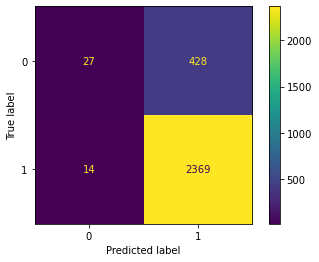

In [25]:
y_pred_log_cv = cross_val_predict(log_best, X_train, y_train, cv=5)

log_conf_mat = confusion_matrix(y_train, y_pred_log_cv)
ConfusionMatrixDisplay(log_conf_mat).plot();

A quick breakdown of the Logistic Regression (tuned) model:
- High True Positives: The model is proficient at identifying the positive emotions.
- High False Positives: The model errs considerably in wrongly classifying negative emotions as positives.
- Low True Negatives: The model struggles with correctly identifying negative emotions.
- Low False Negatives: The model is reasonably good at not misclassifying positive emotions as negatives.

Now, let's move on to the Naive Bayes algorithm to see if we can do better.

#### 2. Naive Bayes

In [26]:
# Initialize the TF-IDF Vectorizer with specified min_df and max_df
tf = TfidfVectorizer(min_df = .01, max_df = .9)

# Transform the training and test data using the TF-IDF Vectorizer
X_train_tf = tf.fit_transform(X_train.values)
X_train_tf = X_train_tf.toarray()
X_test_tf = tf.transform(X_test.values)
X_test_tf = X_test_tf.toarray()

# Initialize the Gaussian Naive Bayes model
nb_model = GaussianNB()

# Perform cross-validation and calculate the mean accuracy
nb_score = np.mean(cross_val_score(nb_model, X_train_tf, y_train, scoring="accuracy"))

print(f"Naive Bayes Cross Validation Accuracy: {nb_score*100:,.2f}%")

# Note: The Naive Bayes model and TF-IDF Vectorizer cannot be fitted into the same pipeline in this case.
# This requires separate steps for vectorization and model training.

Naive Bayes Cross Validation Accuracy: 41.93%


In [28]:
# Grid search for hyperparameter tuning the Naive Bayes model

# Define parameter grid for the Naive Bayes model
# nb_param_grid = {
#     'var_smoothing': [1e-8, 1e-9, 1e-10]
# }

# nb_grid = GridSearchCV(nb_model, nb_param_grid, cv=5, verbose=10, scoring='accuracy')
# nb_grid.fit(X_train_tf, y_train)

# Below are results from the grid search
nb_best_params = {'var_smoothing': 1e-08}

nb_best = GaussianNB(**nb_best_params)

nb_best_score = 0.43517152296495015

print(f"Tuned Naive Bayes Cross Validation Accuracy: {nb_best_score*100:,.2f}%")

Tuned Naive Bayes Cross Validation Accuracy: 43.52%


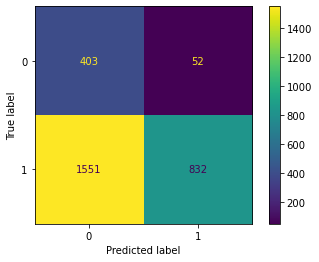

In [29]:
y_pred_nb_cv = cross_val_predict(nb_best, X_train_tf, y_train, cv=5)

nb_conf_mat = confusion_matrix(y_train, y_pred_nb_cv)
ConfusionMatrixDisplay(nb_conf_mat).plot();

A quick Breakdown of the Naive Bayes (tuned) model:

- High True Negatives: The model demonstrates proficiency in identifying negative emotions correctly.
- Low False Positives: The model shows restraint in misclassifying negative emotions as positive, indicating good specificity.
- High False Negatives: The model errs considerably by misclassifying a large number of positive emotions as negatives. This is a point of concern.
- Moderate True Positives: The model exhibits a moderate capability to correctly identify positive emotions.

Overall, the model performed much worse in the cross validation than did the tuned Logistic Regression model. For our final iteration on our binary classification, we'll use the Random Forest classifier. Random Forests better handle imbalanced datasets, and are able to capture complex patterns, making it a strong candidate for improving classification accuracy.

#### 3. Random Forest

In [30]:
# Construct a pipeline with the vectorizer and the Random Forest Classifier
forest_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Perform cross-validation and calculate the mean accuracy
forest_score = np.mean(cross_val_score(forest_pipe, X_train, y_train, scoring="accuracy"))

print(f"Random Forest Cross Validation Accuracy: {forest_score*100:,.2f}%")

Random Forest Cross Validation Accuracy: 85.48%


In [59]:
# Grid search for hyperparameter tuning the Random Forest

# Define parameter grid for the Naive Bayes model
# forest_param_grid = {
#     'tf__min_df': [.01, .02, .03],
#     'tf__max_df': [.88, .90, .92],
#     'tf__ngram_range': [(1,1), (1,2), (1,3)],
#     'rf__n_estimators': [86, 88, 90],
#     'rf__min_samples_split': [1, 2, 3],
#     'rf__class_weight': [None, 'balanced', 'balanced_subsample']   
# }

# forest_grid = GridSearchCV(forest_pipe, forest_param_grid, cv=5, verbose=10, scoring='accuracy')
# forest_grid.fit(X_train_tf, y_train)

# Below are results from the grid search

forest_tf_best_params = {
    'max_df': 0.88, 
    'min_df': 0.01, 
    'ngram_range': (1, 1)
}

forest_best_params = {
    'class_weight': None, 
    'min_samples_split': 2, 
    'n_estimators': 88,
    'random_state': 42, 
}

forest_best = Pipeline([
    ('tf', TfidfVectorizer(**forest_tf_best_params)),
    ('rf', RandomForestClassifier(**forest_best_params))
])

forest_best_score = 0.8558871749012594

print(f"Tuned Random Forest Cross Validation Accuracy: {forest_best_score*100:,.2f}%")

Tuned Random Forest Cross Validation Accuracy: 85.59%


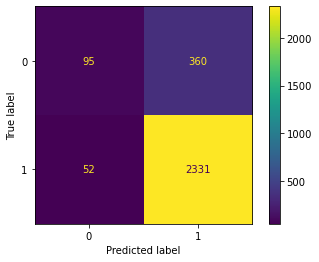

In [32]:
y_pred_forest_cv = cross_val_predict(forest_best, X_train, y_train, cv=5)

forest_conf_mat = confusion_matrix(y_train, y_pred_forest_cv)
ConfusionMatrixDisplay(forest_conf_mat).plot();

A quick breakdown of the Random Forest model:
- Moderate True Negatives: The model demonstrates some ability to identify negative emotions but could be improved.
- High False Positives: The model errs significantly by misclassifying a considerable number of negative emotions as positive. This indicates a lack of specificity.
- Low False Negatives: The model performs well in avoiding the misclassification of positive emotions as negative, which is commendable.
- High True Positives: The model excels at correctly identifying positive emotions, indicating strong sensitivity.

We thus selected the Random Forest Classifier for our final iteration in binary classification. Our rationale for this choice hinges on its high accuracy, which aligns with our designated evaluation metric. Let's test it on unseen data.

In [96]:
forest_best.fit(X_train, y_train)
y_pred_forest_best = forest_best.predict(X_test)
forest_best_test_acc = accuracy_score(y_test, y_pred_forest_best)

print(f"Tuned Random Forest Accuracy Score on Unseen Data: {forest_best_test_acc*100:,.2f}%")

Tuned Random Forest Accuracy Score on Unseen Data: 85.77%


Not bad at all, with respect to accuracy! This will be the model we choose for our binary approach given its high accuracy score.

Next, we also wanted to see if a multiclass classification approach would yield insights useful for our tweet sentiment analysis, so in the next section we'll explore that. However, as mentioned, the binary approach yielded much more fruitful insights than the multiclass approach.

### Approach 2 - Multiclass Classification

#### Multiclass Model Rationale
For multiclass classification, we diversified our model portfolio to capture the nuanced sentiments—positive, negative, and neutral. The models chosen for this approach are selected based on their individual strengths in handling multi-class problems and their compatibility with text data.

1. **K-Nearest Neighbors (K-NN)**: This model was chosen for its ability to detect non-linear decision boundaries. K-NN is often effective when the data forms distinct clusters, and given the high-dimensional nature of text data, this method can be advantageous.

2. **Decision Tree Classifier**: This model offers high interpretability and can capture complex relationships in the data. It also serves as a basis for our ensemble model, Random Forest.

3. **Random Forest Classifier**: Building upon the Decision Tree model, Random Forest was included to improve the robustness and accuracy of the classification. Its ensemble nature allows it to average out biases and reduce overfitting.

4. **Neural Network**: Finally, we deployed a Neural Network model to capture complex, high-level features in the text. Neural Networks are particularly useful when the relationships between the features are intricate and not easily linearly separable.

Each model was subjected to hyperparameter tuning to extract the best performance possible. But before we model, we'd need to encode the original dataset differently - we now have to account for positive, negative *and* neutral emotions (postives will be labeled as 1, negatives as 0, and neutrals as 2).

In [42]:
# Import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [36]:
# Create a copy of the original dataframe
df_multi_ = df.copy()

# Check emotion value count
df_multi_["emotion"].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

As we can see above, we in fact have 4 categories within our `'emotion'` column. However, we're only concerned with 3. The `'I can't tell'` entries are a very small subset of our data, and don't give us much information, so we'll go ahead and drop those.

In [37]:
# Drop "I can't tells" from the dataset
df_multi = df_multi_[df_multi_["emotion"] != "I can't tell"]
df_multi['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

Now that that's done, we can encode our three emotion categories.

In [41]:
# Create a dictionary to encode emotions
emotion_map_multi = {
    'No emotion toward brand or product': 2,
    'Positive emotion': 1,
    'Negative emotion': 0
}

df_multi['emotion_encoded'] = df_multi['emotion'].map(emotion_map_multi)
df_multi['emotion_encoded'].value_counts()

2    5388
1    2978
0     570
Name: emotion_encoded, dtype: int64

We'll then split our data into training and testing sets.

In [43]:
# Store X and y
X_multi = df_multi["processed_tweet"]
y_multi = df_multi["emotion_encoded"]

# Train test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=.2, random_state=42
)

# Inspect shape
X_train_m.shape, X_test_m.shape, y_train_m.shape, y_test_m.shape

((7148,), (1788,), (7148,), (1788,))

We're now ready to build our models and tune them as we did for our binary approach.

#### 1. K-Nearest Neighbors

In [54]:
# Construct a pipeline with the vectorizer and the KNN Classifier
knn_pipe = Pipeline([
    ("tf", TfidfVectorizer(stop_words="english")), 
    ("knn", KNeighborsClassifier())
])

# Run cross validation
knn_pipe_score = np.mean(cross_val_score(knn_pipe, X_train_m, y_train_m, scoring="accuracy", cv=5))

print(f"KNN Cross Validation Accuracy Score: {knn_pipe_score*100:,.2f}%")

KNN Cross Validation Accuracy Score: 63.26%


In [60]:
# Grid search for hyperparameter tuning the KNN Classifier

# knn_param_grid = {
#     'knn__n_neighbors': [3, 5, 7],
#     'knn__weights': ['uniform', 'distance'],
#     'vectorizer__ngram_range': [(1, 1), (1, 2)],
#     'vectorizer__min_df': [0.05, 0.1, 0.15, 0.2],
#     'vectorizer__max_df': [0.9, 0.95, 1.0]
# }

# knn_grid = GridSearchCV(knn_pipe, knn_param_grid, scoring="accuracy", cv=5, n_jobs=-2, verbose=10)
# knn_grid.fit(X_train_m, y_train_m)

# Below are results from the grid search

knn_best_params = {
    'n_neighbors': 7, 
    'weights': 'uniform'
}

knn_tf_best_params = {
    'max_df': 1.0, 
    'min_df': 0.05, 
    'ngram_range': (1, 2)
}

knn_best = Pipeline([
    ('tf', TfidfVectorizer(**knn_tf_best_params)),
    ('knn', KNeighborsClassifier(**knn_best_params))
])

knn_best_score = 0.5595963728364008

print(f"Tuned KNN Cross Validation Accuracy Score: {knn_best_score*100:,.2f}%")

Tuned KNN Cross Validation Accuracy Score: 55.96%


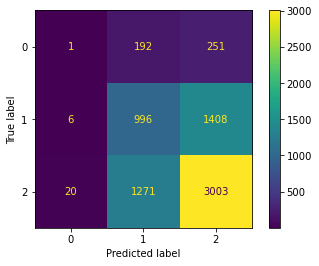

In [61]:
y_pred_knn_cv = cross_val_predict(knn_best, X_train_m, y_train_m, cv=5)

knn_conf_mat = confusion_matrix(y_train_m, y_pred_knn_cv)
ConfusionMatrixDisplay(knn_conf_mat).plot();

A quick breakdown of the KNN (tuned) Model:

- True Positives (for Negative Class - '0'): The model only correctly identified 1 negative tweet, which is significantly low and indicates poor performance in capturing negative sentiments.
- True Positives (for Positive Class - '1'): The model correctly identified 996 positive tweets. This is moderate but should ideally be higher.
- True Positives (for Neutral Class - '2'): The model correctly identified 3003 neutral tweets, which is relatively high and indicates better performance in capturing neutral sentiments.
- False Positives: The model misclassified many tweets across all classes but most significantly for the neutral class ('2'), with 1408 and 1271 false positives from the negative and positive classes, respectively.
- False Negatives: The model also has a high rate of false negatives, especially for the positive and neutral classes. For instance, it misclassified 1408 true positive tweets as neutral and 1271 true neutral tweets as positive.

Noteably, we're at a much worse start than the logistic regression in our binary approach. But let's see if we can do better.

#### 2. Decision Tree

In [64]:
# Construct a pipeline with the vectorizer and the Decision Tree
dt_pipe = Pipeline([
    ("tf", TfidfVectorizer(stop_words="english")), 
    ("dt", DecisionTreeClassifier(random_state=42))
])

dt_pipe_score = np.mean(cross_val_score(dt_pipe, X_train_m, y_train_m, cv=5, scoring="accuracy"))

print(f"Decision Tree Cross Validation Accuracy Score: {dt_pipe_score*100:,.2f}%")

Decision Tree Cross Validation Accuracy Score: 63.05%


In [70]:
# Grid search for hyperparameter tuning the Decision Tree

# dt_param_grid = {
#     'dt__criterion': ['gini', 'entropy'],
#     'dt__max_depth': [10, 20, 30],
#     'vectorizer__ngram_range': [(1, 1), (1, 2)],
#     'vectorizer__min_df': [0.05, 0.1, 0.15, 0.2],
#     'vectorizer__max_df': [0.9, 0.95, 1.0]
# }

# dt_grid = GridSearchCV(dt_pipe, dt_param_grid, scoring="accuracy", cv=5, n_jobs=-2, verbose=10)
# dt_grid.fit(X_train_m, y_train_m)

# Below are results from the grid search

dt_best_params = {
    'criterion': 'gini',
    'max_depth': 10,
    'random_state': 42
}

dt_tf_best_params = {
    'max_df': 1.0,
    'min_df': 0.05,
    'ngram_range': (1, 2)
}

dt_best = Pipeline([
    ('tf', TfidfVectorizer(**dt_tf_best_params)),
    ('knn', DecisionTreeClassifier(**dt_best_params))
])

dt_best_score = 0.6001667751422826

print(f"Tuned Decision Tree Cross Validation Accuracy Score: {dt_best_score*100:,.2f}%")

Tuned Decision Tree Cross Validation Accuracy Score: 60.02%


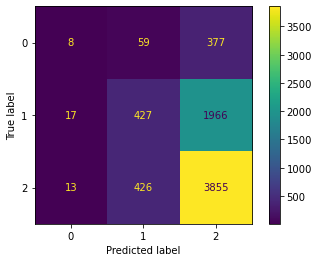

In [71]:
y_pred_dt_cv = cross_val_predict(dt_best, X_train_m, y_train_m, cv=5)

dt_conf_mat = confusion_matrix(y_train_m, y_pred_dt_cv)
ConfusionMatrixDisplay(dt_conf_mat).plot();

A quick breakdown of the Decision Tree (tuned):

- True Positives (for Negative Class - '0'): The model correctly identified 8 negative tweets, which is low and suggests the model is not effective at identifying negative sentiments.
- True Positives (for Positive Class - '1'): The model correctly identified 427 positive tweets, which is moderate but should ideally be higher.
- True Positives (for Neutral Class - '2'): The model correctly identified 3855 neutral tweets, indicating strong performance in capturing neutral sentiments.
- False Positives: The model misclassified a substantial number of tweets across all classes, most notably for the neutral class ('2'), with 1966 and 377 false positives from the positive and negative classes, respectively.
- False Negatives: Similar to false positives, the model has a high rate of false negatives, especially for the positive and neutral classes. For instance, it misclassified 1966 true positive tweets as neutral and 426 true neutral tweets as positive.

The Decision Tree model shows a bias towards classifying tweets as neutral, performing well in identifying neutral sentiments but poorly in capturing negative and positive sentiments. The high number of both false positives and false negatives suggests that the model needs further tuning or may not be the best fit for this specific multiclass problem. Let's move onto a Random Forest.

#### 3. Random Forest (Multiclass)

In [73]:
# Construct a pipeline with the vectorizer and the Random Forest
rf_pipe = Pipeline([
    ("tf", TfidfVectorizer(stop_words="english")), 
    ("dt", RandomForestClassifier(random_state=42))
])

rf_pipe_score = np.mean(cross_val_score(rf_pipe, X_train_m, y_train_m, cv=5, scoring="accuracy"))

print(f"Decision Tree Cross Validation Accuracy Score: {rf_pipe_score*100:,.2f}%")

Decision Tree Cross Validation Accuracy Score: 68.35%


In [78]:
# Grid search for hyperparameter tuning the Decision Tree

# rf_param_grid = {
#     'rf__n_estimators': [50, 100, 200],
#     'rf__min_samples_split': [2, 3, 4],
#     'rf__max_depth': [10, 20, 30],
#     'vectorizer__ngram_range': [(1, 1), (1, 2)],
#     'vectorizer__min_df': [0.05, 0.1, 0.15, 0.2],
#     'vectorizer__max_df': [0.9, 0.95, 1.0]
# }

# rf_grid = GridSearchCV(rf_pipe, rf_param_grid, scoring="accuracy", cv=5, n_jobs=-2, verbose=10)
# rf_grid.fit(X_train_m, y_train_m)

# Below are results from the grid search

rf_best_params = {
    'max_depth': 10,
    'n_estimators': 200,
    'random_state': 42
}

rf_tf_best_params = {
    'min_df': 0.05,
    'ngram_range': (1, 1)
}

rf_best = Pipeline([
    ('tf', TfidfVectorizer(**rf_tf_best_params)),
    ('knn', RandomForestClassifier(**rf_best_params))
])

rf_best_score = 0.6078633892349778

print(f"Tuned Decision Tree Cross Validation Accuracy Score: {rf_best_score*100:,.2f}%")

Tuned Decision Tree Cross Validation Accuracy Score: 60.79%


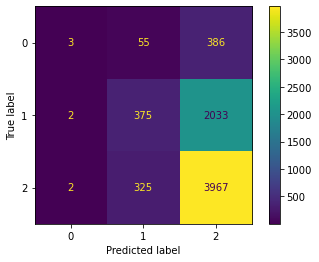

In [79]:
y_pred_rf_cv = cross_val_predict(rf_best, X_train_m, y_train_m, cv=5)

rf_conf_mat = confusion_matrix(y_train_m, y_pred_rf_cv)
ConfusionMatrixDisplay(rf_conf_mat).plot();

A quick breakdown of the Random Forest (tuned):

- True Positives (for Negative Class - '0'): The model correctly identified 3 negative tweets, which is exceedingly low and indicates a lack of proficiency in capturing negative sentiments.
- True Positives (for Positive Class - '1'): The model correctly identified 375 positive tweets, which is moderate but not optimal given the dataset.
- True Positives (for Neutral Class - '2'): The model correctly identified 3967 neutral tweets, indicating robust performance in this class.
- False Positives: The model has a high rate of false positives, particularly in the neutral class ('2'). It misclassified 2033 positive and 386 negative tweets as neutral.
- False Negatives: Similar to false positives, the model also demonstrates a high rate of false negatives, especially for the positive and neutral classes. For instance, 2033 true positive tweets were misclassified as neutral, and 325 true neutral tweets were misclassified as positive.

The Random Forest model is highly biased towards classifying tweets as neutral and performs poorly in identifying negative and positive sentiments. It also performed worse than the untuned model. Let's iterate one more time - this time, we use a neural network. However, we'll see that even that doesnt do much for us on the front of accuracy.

#### 4. Neural Network

Let's first import the necessary modules to build a neural network. We work with `tensorflow`'s `keras` API.

In [82]:
# Import Sequential Model, Dense layer, and one-hot encoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder

In the case of the neural network model, both the feature matrix $X$ and the target vector $y$ undergo different preprocessing steps compared to traditional machine learning models. For $X$:

In [84]:
# The text data is vectorized using the TF-IDF technique, similar to previous models. 
# However, the sparse matrix is converted to a dense matrix, which is a requirement 
# for neural networks in TensorFlow/Keras

vectorizer = TfidfVectorizer(stop_words="english")
X_train_vec = vectorizer.fit_transform(X_train_m)
X_test_vec = vectorizer.transform(X_test_m)

X_train_vec_dense = X_train_vec.todense()
X_test_vec_dense = X_test_vec.todense()

For $y$:

In [85]:
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train_m.values.reshape(-1, 1))

We'll now build the model. We also add a dropout layer, a regularization technique that prevents overfitting by randomly setting a fraction of input units to 0 at each update during training time. This helps to make the model more robust and improves generalization.

In [91]:
# Import Dropout layer
from tensorflow.keras.layers import Dropout

# Model architecture
nn = Sequential()
nn.add(Dense(10, input_dim=X_train_vec_dense.shape[1], activation='relu'))
nn.add(Dropout(0.5))  # Adding dropout with rate 0.5
nn.add(Dense(3, activation='softmax'))

# Compilation
nn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Training
nn.fit(X_train_vec_dense, y_train_encoded, epochs=3, batch_size=1, validation_split=0.2);

Epoch 1/3
5718/5718 [==============================] - 5s 944us/step - loss: 0.8443 - accuracy: 0.6116 - val_loss: 0.7705 - val_accuracy: 0.6406
Epoch 2/3
5718/5718 [==============================] - 5s 865us/step - loss: 0.7315 - accuracy: 0.6777 - val_loss: 0.7309 - val_accuracy: 0.6713
Epoch 3/3
5718/5718 [==============================] - 5s 858us/step - loss: 0.6529 - accuracy: 0.7226 - val_loss: 0.7201 - val_accuracy: 0.6846


As we can see, the neural network did not substantially improve compared to the initial Random Forest classifier. With that said, it did yield the highest validation accuracy, so let's use it and test its accuracy on unseen data.

In [93]:
y_pred_nn = np.argmax(nn.predict(X_test_vec_dense), axis=1)

nn_test_acc = accuracy_score(y_test_m, y_pred_nn)

print(f"Neural Network Accuracy Score on Unseen Data: {nn_test_acc*100:,.2f}%")

Neural Network Accuracy Score on Unseen Data: 66.16%


## Model Selection

It's evident that our binary classification approach is the most suitable for providing actionable insights for SXSW. Despite the multifaceted capabilities of neural networks and other multiclass classifiers, they failed to yield results robust enough for practical application. Specifically, an accuracy score of 66.16% for our neural network on multiclass classification is insufficient for deriving business-critical decisions.

Therefore, we recommend adopting the binary classification model, particularly the Random Forest Classifier, which demonstrated superior performance. This would enable SXSW to garner more accurate and actionable insights regarding consumer sentiment towards Apple and Google products.